In [2]:
import tensorflow as tf
from keras.datasets.mnist import load_data
import numpy as np

(x_train, y_train), (x_test, y_test) = load_data()
x_train = ((x_train/255 - 0.5) * 2).astype(np.float32).reshape(x_train.shape[0], -1)
x_test = ((x_test/255 - 0.5) * 2).astype(np.float32).reshape(x_test.shape[0], -1)

print(f"{x_train.shape=}")
print(f"{y_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_test.shape=}")

x_train.shape=(60000, 784)
y_train.shape=(60000,)
x_test.shape=(10000, 784)
y_test.shape=(10000,)


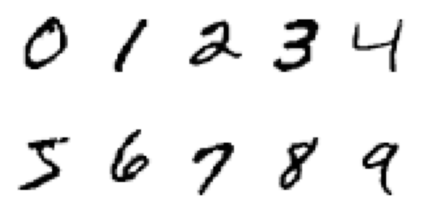

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 2, ncols=5)
ax = ax.flatten()

for i in range(10):
  img = x_train[y_train == i][0].reshape(28,28)
  ax[i].imshow(img, cmap="Greys")
  ax[i].axis('off')
plt.tight_layout()
plt.show()

In [29]:
import numpy.typing as npt

class NeuralNetMLP:
  w_h: npt.NDArray 
  b_h: npt.NDArray
  w_out: npt.NDArray
  b_out: npt.NDArray
  def __init__(self, n_hidden=30, l2=0, epochs=100, eta=0.001, shuffle=True, minibatch_size = 1, seed=None):
    self.random = np.random.RandomState(seed)
    self.n_hidden = n_hidden
    self.l2 = l2
    self.epochs = epochs
    self.eta = eta
    self.shuffle = shuffle
    self.minibatch_size = minibatch_size

  def _onehot(self, y, n_classes):
    one_hot = np.zeros((y.shape[0], n_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot
  def _sigmoid(self, z):
    return 1./ (1. + np.exp(-np.clip(z, -250., 250.)))

  def _forward(self, X):
    # (n_s, n_features) dot (n_features, n_hidden) -> (n_s, n_hidden)  
    z_h = np.dot(X, self.w_h) + self.b_h
    a_h = self._sigmoid(z_h)
    # (n_s, n_hidden) dot (n_hidden, n_classes) -> (n_s, n_classes) 
    z_out = np.dot(a_h, self.w_out) + self.b_out
    a_out = self._sigmoid(z_out)
    return z_h, a_h, z_out, a_out

  def _compute_loss(self, y_enc, output):
    L2_term = (np.sum(self.w_h * self.w_h) + np.sum(self.w_out * self.w_out)) * self.l2
    term1 = -y_enc * np.log(output)
    term2 = (1. - y_enc) * np.log(1. - output)
    cost = np.sum(term1 - term2) / y_enc.shape[0] + L2_term
    return cost

  def predict(self, X):
    z_h, a_h, z_out, a_out = self._forward(X)
    y_pred = np.argmax(a_out, axis=1)
    return y_pred

  def fit(self, x_train, y_train, x_valid, y_valid):
    n_output = np.unique(y_train).shape[0]  
    n_features = x_train.shape[1]
    

    self.w_h = self.random.normal(loc=0., scale=1.0, size=(n_features, self.n_hidden))
    self.b_h = np.zeros(self.n_hidden)

    self.w_out = self.random.normal(loc=0., scale=1.0, size=(self.n_hidden, n_output))
    self.b_out = np.zeros(n_output)

    epoch_strlen = len(str(self.epochs))
    self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

    y_train_enc = self._onehot(y_train, n_output)

    for i in range(self.epochs):

      indices = np.arange(x_train.shape[0])
      
      if self.shuffle:
        self.random.shuffle(indices)

      for start_idx in range(0, x_train.shape[0], self.minibatch_size):
        batch_idx = indices[start_idx: start_idx + self.minibatch_size]  

        z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])

        # (n_sample, n_classes) 
        sigma_out = a_out - y_train_enc[batch_idx]
        # (n_sample, n_hidden)
        sigmoid_derivative_h = (a_h) * (1. - a_h)
        # (n_sample, n_classes) dot (n_classes, n_hidden) -> (n_sample, n_hidden)
        sigma_h = np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h

        # (n_features, n_sample) dot (n_sample, n_hidden) -> (n_features, n_hidden)
        grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
        grad_b_h = np.sum(sigma_h, axis=0)

        # (n_hidden, n_sample) dot (n_sample, n_classes) -> (n_hidden, n_classes)
        grad_w_out = np.dot(a_h.T, sigma_out)
        grad_b_out = np.sum(sigma_out, axis=0)

        delta_w_h = grad_w_h + self.l2 * self.w_h
        delta_b_h = grad_b_h
        self.w_h -= self.eta * delta_w_h
        self.b_h -= self.eta * delta_b_h

        delta_w_out = grad_w_out + self.l2 * self.w_out
        delta_b_out = grad_b_out
        self.w_out -= self.eta * delta_w_out
        self.b_out -= self.eta * delta_b_out

      z_h, a_h, z_out, a_out = self._forward(x_train)
      cost = self._compute_loss(y_train_enc, a_out)

      y_train_pred = self.predict(x_train)
      y_valid_pred = self.predict(x_valid)

      train_acc = np.sum(y_train == y_train_pred).astype(np.float32) / x_train.shape[0]
      valid_acc = np.sum(y_valid == y_valid_pred).astype(np.float32) / x_valid.shape[0]

      print(f"epoch: {i:0{epoch_strlen}d} | Cost: {cost:.3f} | Train/Valid Acc: {train_acc:.4f}/{valid_acc:.4f}")

      self.eval_['cost'].append(cost)
      self.eval_['train_acc'].append(train_acc)
      self.eval_['valid_acc'].append(valid_acc)
    return self   
  def save_weights(self):
    np.savez_compressed(f"weight-{self.epochs}-{self.eval_['cost'][-1]:.3f}-{self.eval_['train_acc'][-1]:.4f}-{self.eval_['valid_acc'][-1]:.4f}", w_h=self.w_h, b_h=self.b_h, w_out=self.w_out, b_out=self.b_out)
  
  def load_weights(self, filename):
    weights = np.load(filename)

    self.w_h = weights['w_h']
    self.b_h = weights['b_h']
    self.w_out = weights['w_out']
    self.b_out = weights['b_out']

In [58]:
nn = NeuralNetMLP(n_hidden=500, epochs=200, l2=0.05,eta=0.001, minibatch_size=100, shuffle=True, seed=0)
print(f"{x_train[:55000].shape=}")
print(f"{y_train[:55000].shape=}")
print(f"{x_train[55000:].shape=}")
print(f"{y_train[55000:].shape=}")
nn.fit(x_train=x_train[:55000], y_train=y_train[:55000], x_valid=x_train[55000:], y_valid=y_train[55000:])

x_train[:55000].shape=(55000, 784)
y_train[:55000].shape=(55000,)
x_train[55000:].shape=(5000, 784)
y_train[55000:].shape=(5000,)
epoch: 000 | Cost: 18724.403 | Train/Valid Acc: 0.8073/0.8362
epoch: 001 | Cost: 17716.135 | Train/Valid Acc: 0.8556/0.8782
epoch: 002 | Cost: 16763.863 | Train/Valid Acc: 0.8777/0.8970
epoch: 003 | Cost: 15863.648 | Train/Valid Acc: 0.8919/0.9076
epoch: 004 | Cost: 15012.340 | Train/Valid Acc: 0.9033/0.9158
epoch: 005 | Cost: 14207.140 | Train/Valid Acc: 0.9106/0.9234
epoch: 006 | Cost: 13445.449 | Train/Valid Acc: 0.9177/0.9264
epoch: 007 | Cost: 12724.865 | Train/Valid Acc: 0.9230/0.9304
epoch: 008 | Cost: 12043.118 | Train/Valid Acc: 0.9287/0.9352
epoch: 009 | Cost: 11398.101 | Train/Valid Acc: 0.9332/0.9376
epoch: 010 | Cost: 10787.796 | Train/Valid Acc: 0.9357/0.9404
epoch: 011 | Cost: 10210.315 | Train/Valid Acc: 0.9410/0.9416
epoch: 012 | Cost: 9663.897 | Train/Valid Acc: 0.9429/0.9436
epoch: 013 | Cost: 9146.853 | Train/Valid Acc: 0.9448/0.9436
epoc

In [69]:
nn.save_weights()

In [65]:
np.argmax(nn.eval_['valid_acc'])

180

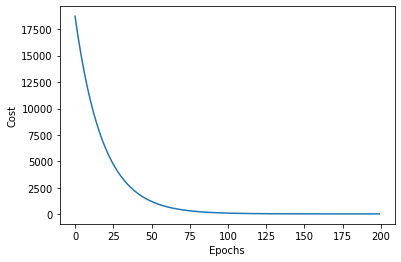

In [66]:
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

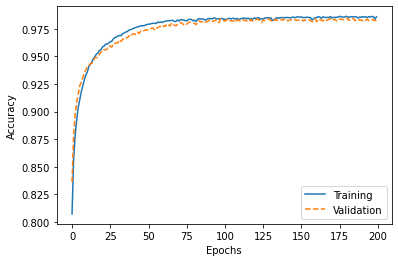

In [67]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [68]:
y_test_pred = nn.predict(x_test)
acc = np.sum(y_test == y_test_pred).astype(np.float32) / x_test.shape[0]
print(f"Test accuracy: {acc:.4f}")

Test accuracy: 0.9775
